In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import utils
import datasets
import keras.backend as K
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.layers import Input, Reshape
from keras.layers import Conv2D, MaxPooling2D, Activation , Flatten, Dense
from keras.layers import RNN, LSTM, GRU, ConvLSTM2D
from keras.layers import Deconv3D,UpSampling3D, Activation

Using TensorFlow backend.


In [2]:
# some magic commands
# %load_ext autoreload
%matplotlib inline

[load_dataset] loading ShapeNet
[construct_paths] for dir ShapeNet
[fetch_renders_from_disk]


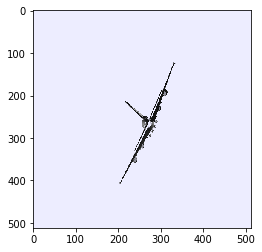

In [3]:
# load data and display random example
X=datasets.load_dataset("ShapeNet")
input_shape=X.shape[1:]
plt.imshow(random.choice(X))

In [4]:
# net parameters
conv_filter_count = [96, 128, 256, 256, 256, 256]
deconv_filter_count = [128, 128, 128, 64, 32, 2]

In [8]:
# encoder network
print(X.shape)
cur_tensor=Input(shape=input_shape);

k_s = [3,3]
for i in range(6):   
    ks=[7,7] if i is 0 else k_s       
    cur_tensor=Conv2D(filters=conv_filter_count[i],kernel_size= k_s)(cur_tensor)
    cur_tensor=MaxPooling2D()(cur_tensor)
    cur_tensor=Activation('relu')(cur_tensor)
    print(cur_tensor.shape)

(5, 512, 512, 3)
(?, 255, 255, 96)
(?, 126, 126, 128)
(?, 62, 62, 256)
(?, 30, 30, 256)
(?, 14, 14, 256)
(?, 6, 6, 256)


In [ ]:
# construct feature vector
cur_tensor=Flatten()(cur_tensor)
print(cur_tensor.shape)
cur_tensor=Dense(1024)(cur_tensor)
print(cur_tensor.shape)

In [ ]:
g_cell=GRU(1024)
cur_tensor=Reshape([1,1024])(cur_tensor)
cur_tensor=g_cell(cur_tensor)

In [ ]:
# rnn module
# %autoreload

gru_grid= utils.grid3D(

In [ ]:
cur_tensor=gru_grid[0,0,0](cur_tensor)

In [ ]:
# decoder network
for i in range(6):
    cur_tensor=Deconv3D(filters=deconv_filter_count[i],kernel_size=(3,3,3))(cur_tensor)
    cur_tensor=UpSampling3D()(cur_tensor)
    cur_tensor=Activation('relu')(cur_tensor)
    print(cur_tensor.shape)
    
print(cur_tensor.shape())

In [ ]:
net = Model(input=input_tensor,output=cur_tensor)

In [ ]:
net.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
os.system("rm -rf ./logs/*")
tensor_board=TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
net.fit(X,np.random.rand(len(X),1024),epochs=1,callbacks=[tensor_board])